# Plantilla para proyecto 4. 
# Red neural recurrente para regresión.

La red impementada en este programa "aprende" (con una neurona) a contar los "unos" en una secuencia binaria, esto es, resuelve un problema lineal.

El proyecto se trata de modificar ese programa, para que resuelva un problema no lineal: predecir el valor futuro de una serie de datos, dados $n$ valores pasados de la misma serie.

## Librerias

In [1]:
import sys
import numpy as np  
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt  
from matplotlib import cm 
from matplotlib.colors import LogNorm
import seaborn as sns  
sns.set_style('darkgrid')

# Semilla aleatoria fija
np.random.seed(seed=1)

## Generación de los datos.

#### Datos para la aproximación lineal.

In [2]:
nb_of_samples = 20
sequence_len = 10
# Crea las secuencias
X = np.zeros((nb_of_samples, sequence_len))
for row_idx in range(nb_of_samples):
    X[row_idx,:] = np.around(np.random.rand(sequence_len)).astype(int)
# Crea las etiquetas
t = np.sum(X, axis=1)

#### Datos para la aproximación no lineal.

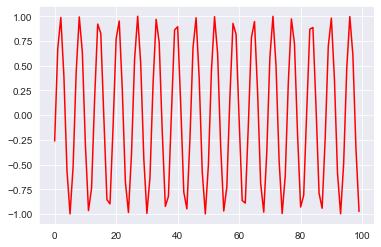

In [3]:
import numpy as np
import math 


sin_wave = np.array([math.sin(x) for x in np.arange(200)])

X = []
y = []

seq_len = 50
num_records = len(sin_wave) - seq_len

for i in range(num_records - 50):
    X.append(sin_wave[i:i+seq_len])
    y.append(sin_wave[i+seq_len])
    
X = np.array(X)
X = np.expand_dims(X, axis=1)

y = np.array(y)
y = np.expand_dims(y, axis=1)


plt.plot(y[:, 0], 'r')
plt.show()

## Forward pass.

In [4]:
def update_state(xk, sk, wx, wRec):
    """
    Calcula el estado hk a partir del estado anterior (sk) y la entrada 
    actual (xk), utilizando los pesos de entrada (wx) y los pesos recursivos (wRec). 
    recursivos (wRec)
    """
    return xk * wx + sk * wRec
#LA FUNCION DE TRANSFERENCIA ES Y = X


def forward_states(X, wx, wRec):
    """
    Despliega la red y calcula todas las activaciones de estado, 
    dada la entrada X, los pesos de entrada (wx) y los pesos recursivos 
    (wRec). Devuelve las activaciones de estado en una matriz, la última 
    columna S[:,-1] contiene las activaciones finales.
    """
    # Inicializa la matriz que contiene todos los estados para todas 
    # secuencias de entrada. El estado inicial s0 es 0.
    S = np.zeros((X.shape[0], X.shape[1]+1))
    # Usa la relación de recurrencia definida por update_state para actualizar 
    # los estados a través del tiempo.
    for k in range(0, X.shape[1]):
        # S[k] = S[k-1] * wRec + X[k] * wx
        S[:,k+1] = update_state(X[:,k], S[:,k], wx, wRec)
    return S


def loss(y, t): 
    """MSE entre los objetivos t y los resultados y."""
    return np.mean((t - y)**2)

## Backward pass... y otras cosas...

In [5]:
def output_gradient(y, t):
    """
    Gradiente de la función de pérdida MSE con respecto a la salida y.
    """
    return 2. * (y - t)


def backward_gradient(X, S, grad_out, wRec):
    """
    Propaga hacia atrás el gradiente calculado en la salida (grad_out) 
    a través de la red. Acumula los gradientes de los parámetros 
    wX y wRec por cada capa. Devuelve los gradientes 
    como una tupla y los gradientes a la salida de cada capa.
    """
    # Inicializa la matriz que almacena los gradientes de la pérdida con 
    # respecto a los estados.
    grad_over_time = np.zeros((X.shape[0], X.shape[1]+1))
    grad_over_time[:,-1] = grad_out
    # Pone en 0 las acumulaciones de gradiente
    wx_grad = 0
    wRec_grad = 0
    for k in range(X.shape[1], 0, -1):
        # Calcula los parámetros y accumula los resultados.
        wx_grad += np.sum(
            np.mean(grad_over_time[:,k] * X[:,k-1], axis=0))
        wRec_grad += np.sum(
            np.mean(grad_over_time[:,k] * S[:,k-1]), axis=0)
        # Calcula el gradiente en la salida de la capa anterior
        grad_over_time[:,k-1] = grad_over_time[:,k] * wRec
    return (wx_grad, wRec_grad), grad_over_time

#### Comprobación de gradiente

In [6]:
nb_of_samples = 20
sequence_len = 10
# Crea las secuencias
X = np.zeros((nb_of_samples, sequence_len))
for row_idx in range(nb_of_samples):
    X[row_idx,:] = np.around(np.random.rand(sequence_len)).astype(int)
# Crea las etiquetas
t = np.sum(X, axis=1)

# Establece los parámetros de peso utilizados durante la comprobación del gradiente
params = [1.2, 1.2]  # [wx, wRec]
# Establece el pequeño cambio para calcular el gradiente numérico
eps = 1e-7
# Calcula los gradientes de retropropagación
S = forward_states(X, params[0], params[1])
grad_out = output_gradient(S[:,-1], t)
backprop_grads, grad_over_time = backward_gradient(
    X, S, grad_out, params[1])
# Calcula el gradiente numérico de cada parámetro de la capa
for p_idx, _ in enumerate(params):
    grad_backprop = backprop_grads[p_idx]
    # + eps
    params[p_idx] += eps
    plus_loss = loss(forward_states(X, params[0], params[1])[:,-1], t)
    # - eps
    params[p_idx] -= 2 * eps
    min_loss = loss(forward_states(X, params[0], params[1])[:,-1], t)
    # resetea el valor de param
    params[p_idx] += eps
    # calcula el gradiente numérico
    grad_num = (plus_loss - min_loss) / (2*eps)
    # Aumenta el error si numerical grade no es cercano a
    #  el gradiente de retropropagación
    if not np.isclose(grad_num, grad_backprop):
        raise ValueError((
            f'Gradiente numérico de {grad_num:.6f} no es cercano a '
            f'el gradiente de retropropagación de {grad_backprop:.6f}!'))
print('No se encontraron errores en la comparación')
#


No se encontraron errores en la comparación


#### Actualizacion de los pesos con Rprop

In [7]:
# Define función de optimisación Rprop 
def update_rprop(X, t, W, W_prev_sign, W_delta, eta_p, eta_n):
    """
    Actualiza los valores de Rprop en una iteración.
    Args:
        X: datos de entrada.
        t: objetivos.
        W: parámetros de peso actuales.
        W_prev_signo: Signo anterior del gradiente W.
        W_delta: Valores de actualización de Rprop (Delta).
        eta_p, eta_n: Hiperparámetros de Rprop.
    Devuelve:
        (W_delta, W_sign): Actualización del peso y signo del último
                           gradiente.
    """
    # Realiza pasos hacia delante y hacia atrás para obtener los gradientes
    S = forward_states(X, W[0], W[1])
    grad_out = output_gradient(S[:,-1], t)
    W_grads, _ = backward_gradient(X, S, grad_out, W[1])
    W_sign = np.sign(W_grads) # Signo del nuevo gradiente
    # Actualizar el Delta (valor de actualización) para cada 
    # parámetro por separado
    for i, _ in enumerate(W):
        if W_sign[i] == W_prev_sign[i]:
            W_delta[i] *= eta_p
        else:
            W_delta[i] *= eta_n
    return W_delta, W_sign


20
Los pesos finales son: wx = 1.0000,  wRec = 1.0000


Text(0, 0.5, 'valor de los pesos')

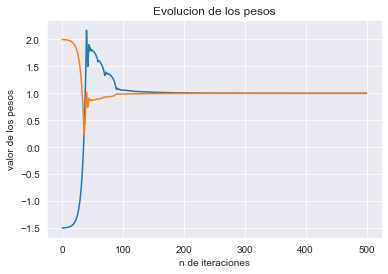

In [8]:
nb_of_samples = 20
sequence_len = 10
# Crea las secuencias
X = np.zeros((nb_of_samples, sequence_len))
for row_idx in range(nb_of_samples):
    X[row_idx,:] = np.around(np.random.rand(sequence_len)).astype(int)
# Crea las etiquetas
t = np.sum(X, axis=1)

print(len(X))

# Perform Rprop optimisation

# Fija los hiperparámetros
eta_p = 1.2
eta_n = 0.5

# Fija los parámetros ininciales
W = [-1.5, 2]  # [wx, wRec]
W_delta = [0.001, 0.001]  # Actualiza los valores (Delta) para W
W_sign = [0, 0]  # Signo anterior de W

ls_of_ws = [(W[0], W[1])]  # Lista de pesos a graficar
# Itera  500 veces
for i in range(500):
    # Actualiza los valores y signos del ultimo gradiente
    W_delta, W_sign = update_rprop(
        X, t, W, W_sign, W_delta, eta_p, eta_n)
    # Actualiza cada peso separadamente 
    for i, _ in enumerate(W):
        W[i] -= W_sign[i] * W_delta[i]
    ls_of_ws.append((W[0], W[1]))  # Acumula los pesos en una lista para graficar

print(f'Los pesos finales son: wx = {W[0]:.4f},  wRec = {W[1]:.4f}')
plt.plot(ls_of_ws)
plt.title('Evolucion de los pesos')
plt.xlabel("n de iteraciones")
plt.ylabel("valor de los pesos")

#### Desempeño.

In [9]:
test_inpt = np.asmatrix([[ np.random.randint(0, 2) for x in range(0,12)]])
print(test_inpt)
test_outpt = forward_states(test_inpt, W[0], W[1])[:,-1]
sum_test_inpt = test_inpt.sum()
print((
    f'Salida esperada: {sum_test_inpt:d} vs Salida del modelo: '
    f'{test_outpt[0]:.2f}'))

[[0 0 1 1 0 0 1 1 0 1 0 1]]
Salida esperada: 6 vs Salida del modelo: 6.00


#### Funciones de tranferencia.
La funcion de transferencia de este modelo es Y = X por lo cual este modelo no tiene la capacidad de resolver el problema del sin(x)

#### Validacion con conjuntos de data y entrenamiento mas grandes

[[1 1 0 0 1 1 0 0 0 1 1 0 0 1 0 0]]
Salida esperada: 7 vs Salida del modelo: 7.00
[20]
[0.00023180168867931172]
[[0 1 0 1 0 1 1 0 1 1 1 1 0 0 0 1 1 0 1 1 1 1 0 1 0 1 1 0 0 1 1 1 0 0 1 0
  1 1 1 0 1 0 1 1 1 0 1 0 0 1 1 0 0 1 0 1 0 0 1 0 1 0 1 1]]
Salida esperada: 37 vs Salida del modelo: 36.99
[20, 80]
[0.00023180168867931172, 0.008142575210683844]
[[1 1 0 1 0 0 1 1 1 1 1 0 0 1 1 0 1 1 0 1 0 1 0 1 0 0 1 0 0 0 0 1 1 0 1 1
  1 0 0 1 0 0 1 1 1 1 1 1 1 0 0 0 1 0 0 0 0 1 1 0 1 1 0 0 0 1 1 1 0 1 1 1
  0 0 1 0 1 0 0 0 1 0 0 0 1 0 1 0 0 1 1 1 1 1 1 0 0 1 0 1 0 0 1 0 0 1 1 1
  1 1 1 0 0 1 1 1 0 1 1 1 0 1 1 1 1 0 0 0 1 1 0 1 0 1 1 1 0 1 1 1 1 1 1 1
  0 0 1 1 0 1 0 1 0 1 1 0 0 0 1 1 0 0 1 0 0 0 1 0 0 0 1 1 0 0 0 0 0 0 0 0
  1 0 1 1 0 0 1 1 1 0 0 1 1 0 0 1 0 0 0 1 1 1 1 1 1 0 1 1 0 1 1 1 0 0 1 1
  0 0 0 0 0 0 0 0 1 0 0 1 1 0 1 1 0 1 1 1 1 1 1 0 1 0 1 0 0 1 0 0 0 1 1 0
  1 1 1 1]]
Salida esperada: 137 vs Salida del modelo: 136.86
[20, 80, 320]
[0.00023180168867931172, 0.008142575210683844, 0.1360662

Text(0, 0.5, 'Error')

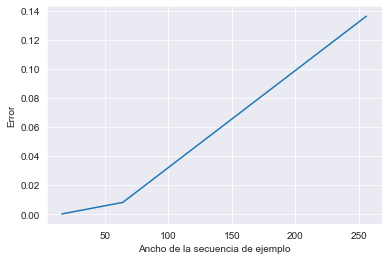

In [10]:
list_examples = []
list_errors = []
nb_of_samples = 20
sequence_len = 10

# Crea las secuencias
X = np.zeros((nb_of_samples, sequence_len))
for row_idx in range(nb_of_samples):
    X[row_idx,:] = np.around(np.random.rand(sequence_len)).astype(int)
  # Crea las etiquetas
t = np.sum(X, axis=1)
for i in range(500):
    # Actualiza los valores y signos del ultimo gradiente
    W_delta, W_sign = update_rprop(
    X, t, W, W_sign, W_delta, eta_p, eta_n)

list_examples.append(nb_of_samples)
test_inpt = np.asmatrix([[ np.random.randint(0, 2) for x in range(0,int(nb_of_samples*80/100))]])
print(test_inpt)
test_outpt = forward_states(test_inpt, W[0], W[1])[:,-1]
sum_test_inpt = test_inpt.sum()
print((
            f'Salida esperada: {sum_test_inpt:d} vs Salida del modelo: '
            f'{test_outpt[0]:.2f}'))
list_errors.append((sum_test_inpt - test_outpt[0]))

nb_of_samples = nb_of_samples * 4
print(list_examples)
print(list_errors)

# Crea las secuencias
X = np.zeros((nb_of_samples, sequence_len))
for row_idx in range(nb_of_samples):
    X[row_idx,:] = np.around(np.random.rand(sequence_len)).astype(int)
  # Crea las etiquetas
t = np.sum(X, axis=1)
for i in range(500):
    # Actualiza los valores y signos del ultimo gradiente
    W_delta, W_sign = update_rprop(
    X, t, W, W_sign, W_delta, eta_p, eta_n)

list_examples.append(nb_of_samples)
test_inpt = np.asmatrix([[ np.random.randint(0, 2) for x in range(0,int(nb_of_samples*80/100))]])
print(test_inpt)
test_outpt = forward_states(test_inpt, W[0], W[1])[:,-1]
sum_test_inpt = test_inpt.sum()
print((
            f'Salida esperada: {sum_test_inpt:d} vs Salida del modelo: '
            f'{test_outpt[0]:.2f}'))
list_errors.append((sum_test_inpt - test_outpt[0]) )

nb_of_samples = nb_of_samples * 4
print(list_examples)
print(list_errors)


# Crea las secuencias
X = np.zeros((nb_of_samples, sequence_len))
for row_idx in range(nb_of_samples):
    X[row_idx,:] = np.around(np.random.rand(sequence_len)).astype(int)
  # Crea las etiquetas
t = np.sum(X, axis=1)
for i in range(500):
    # Actualiza los valores y signos del ultimo gradiente
    W_delta, W_sign = update_rprop(
    X, t, W, W_sign, W_delta, eta_p, eta_n)

list_examples.append(nb_of_samples)
test_inpt = np.asmatrix([[ np.random.randint(0, 2) for x in range(0,int(nb_of_samples*80/100))]])
print(test_inpt)
test_outpt = forward_states(test_inpt, W[0], W[1])[:,-1]
sum_test_inpt = test_inpt.sum()
print((
            f'Salida esperada: {sum_test_inpt:d} vs Salida del modelo: '
            f'{test_outpt[0]:.2f}'))
list_errors.append((sum_test_inpt - test_outpt[0]))

nb_of_samples = nb_of_samples * 4
print(list_examples)
print(list_errors)

   
#exam_list, e_list = calcular_error()
plt.plot([(80/100)*x for x in list_examples],list_errors)
plt.xlabel("Ancho de la secuencia de ejemplo")
plt.ylabel("Error")

#### Parte 2.Implementacion de RNN para regresion no lineal.

Empezamos graficando la data del inicio ya que esta es diferente para la regresion no lineal

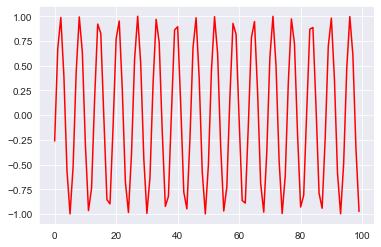

In [11]:
sin_wave = np.array([math.sin(x) for x in np.arange(200)])
X = []
y = []
seq_len = 50
num_records = len(sin_wave) - seq_len
for i in range(num_records - 50):
    X.append(sin_wave[i:i+seq_len])
    y.append(sin_wave[i+seq_len])    
X = np.array(X)
X = np.expand_dims(X, axis=1)
y = np.array(y)
y = np.expand_dims(y, axis=1)
plt.plot(y[:, 0], 'r')
plt.show()

#### Librerias.
Usaremos las librerias de tensorFlow y Keras para re-construir la red RNN 

In [12]:
import tensorflow as tf

#### Especificacion de la red
 Crearemos un modelo secuencial de Keras con 2 neuronas recurrentes, y para la capa de entrada 50 pasos de tiempo , 1 neurona de salida , 100 epocas, optimizador Adam , como funcion de perdida tendremos el error cuadratico medio y nuestra funcion de activacion sera la tangente hiperbolica.

In [13]:
epochs = 100
batch_size = 16
neuronas_capa_oculta = 2

model = tf.keras.Sequential()
model.add(tf.keras.layers.SimpleRNN(neuronas_capa_oculta, activation='tanh', input_shape=(1, 50)))  # Capa RNN con 2 neuronas ocultas
model.add(tf.keras.layers.Dense(1))  # Capa de salida con una sola neurona

model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])  # Configura el optimizador y la función de pérdida

W1115 15:54:45.269769 21368 deprecation.py:506] From C:\WPy64-3740\python-3.7.4.amd64\lib\site-packages\tensorflow\python\ops\init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


#### Entrenamiento de la red

In [14]:
model.fit(X, y, epochs=epochs, batch_size=batch_size)  # Entrena el modelo con los datos de entrada y salida

Epoch 1/100
100/100 [==============================] - 0s 2ms/sample - loss: 0.0443 - acc: 0.0000e+00
Epoch 2/100
100/100 [==============================] - 0s 140us/sample - loss: 0.0175 - acc: 0.0000e+00
Epoch 3/100
100/100 [==============================] - 0s 130us/sample - loss: 0.0120 - acc: 0.0000e+00
Epoch 4/100
100/100 [==============================] - 0s 130us/sample - loss: 0.0111 - acc: 0.0000e+00
Epoch 5/100
100/100 [==============================] - 0s 130us/sample - loss: 0.0096 - acc: 0.0000e+00
Epoch 6/100
100/100 [==============================] - 0s 110us/sample - loss: 0.0074 - acc: 0.0000e+00
Epoch 7/100
100/100 [==============================] - 0s 110us/sample - loss: 0.0064 - acc: 0.0000e+00
Epoch 8/100
100/100 [==============================] - 0s 110us/sample - loss: 0.0055 - acc: 0.0000e+00
Epoch 9/100
100/100 [==============================] - 0s 110us/sample - loss: 0.0046 - acc: 0.0000e+00
Epoch 10/100
100/100 [==============================] - 0s 110us/s

#### Validacion del modelo
A continuacion validaremos nuestro modelo con data de prueba, usaremos la funcion del inicio solo que pediremos que prediga mas valores de los propuestos originalmente.

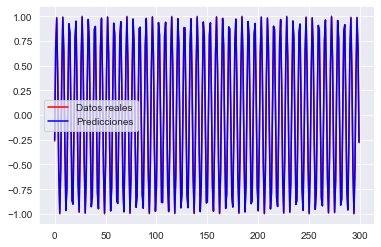

300/300 - 0s - loss: 4.5306e-05 - acc: 0.0000e+00


[4.530602120212279e-05, 0.0]

In [15]:
# Genera nuevos datos de entrada para hacer predicciones
sin_wave = np.array([math.sin(x) for x in np.arange(400)])
x_new = []
y_new = []
seq_len = 50
num_records = len(sin_wave) - seq_len
for i in range(num_records - 50):
    x_new.append(sin_wave[i:i+seq_len])
    y_new.append(sin_wave[i+seq_len])
    
x_new = np.array(x_new)
x_new = np.expand_dims(x_new, axis=1)
y_new = np.array(y_new)
y_new = np.expand_dims(y_new, axis=1)
#////////////////////////////////////////////////////
# Realiza las predicciones con el modelo
y_pred = model.predict(x_new)
y_pred = np.expand_dims(y_pred, axis=1)
# Grafica los resultados

plt.plot(y_new[:, 0], 'r', label='Datos reales')
plt.plot(y_pred[:,0],'b', label='Predicciones')
plt.legend()
plt.show()

model.evaluate(x_new,y_new,verbose=2)

Como podemos observar en la grafica nuestra red predice con bastante precision la funcion seno de x teniendo un error relativamente pequeno 